### Import necessary libraries and Load the MNIST dataset

In [2]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
len(train_images)

60000

In [5]:
test_images.shape

(10000, 28, 28)

In [6]:
len(test_images)

10000

### Build the Neural Network model

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [9]:
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

### Preprocess the data

In [10]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

### Train the model

In [11]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5


I0000 00:00:1723796772.351528    3081 service.cc:146] XLA service 0x7f77c8017ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723796772.351650    3081 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-08-16 11:26:12.394339: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-16 11:26:12.497113: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


111/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7731 - loss: 0.7785

I0000 00:00:1723796774.309659    3081 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8717 - loss: 0.4458
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9661 - loss: 0.1184
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9801 - loss: 0.0730
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9851 - loss: 0.0505
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9893 - loss: 0.0364


In [12]:
test_digits = test_images[0:10]
predictions = model.predict(test_digits)
predictions[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


array([2.5611226e-09, 3.4072797e-10, 1.8708071e-06, 6.0067923e-06,
       5.6787826e-13, 3.1045140e-09, 7.0562303e-14, 9.9999201e-01,
       7.2889637e-09, 7.5762912e-08], dtype=float32)

In [13]:
predictions[0].argmax()

7

In [14]:
predictions[0][7]

0.999992

In [15]:
test_labels[0]

7

### Evaluate the model

In [16]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9732 - loss: 0.0877
test_acc: 0.9785000085830688


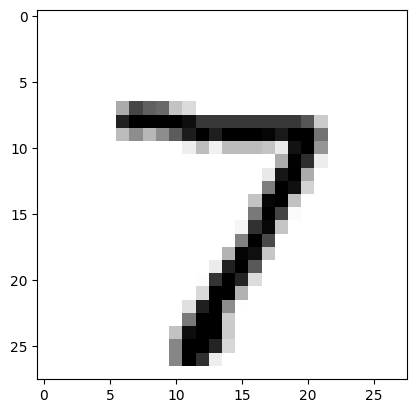

In [18]:
import matplotlib.pyplot as plt
plt.imshow(test_images[0].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

---

### Reimplemnting the same thing but from scratch in tensorflow

### A simple Dense class


In [19]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=-0.1, maxval=0.1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)
    
    @property
    def weights(self):
        return [self.W, self.b]

### A simple Sequential class


In [20]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights += layer.weights
        return weights

In [21]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

### A batch generator


In [22]:
import numpy as np

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

### Running one training step


In [27]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

In [23]:
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(learning_rate * g)

In [24]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

### The full training loop


In [25]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(len(images) // batch_size):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss.numpy()}")

In [28]:
fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
loss at batch 0: 2.266228199005127
loss at batch 100: 2.2135393619537354
loss at batch 200: 2.0849504470825195
loss at batch 300: 1.9795687198638916
loss at batch 400: 1.8738946914672852
Epoch 1
loss at batch 0: 1.7372989654541016
loss at batch 100: 1.7813224792480469
loss at batch 200: 1.6420371532440186
loss at batch 300: 1.5849056243896484
loss at batch 400: 1.517980933189392
Epoch 2
loss at batch 0: 1.37788724899292
loss at batch 100: 1.4685636758804321
loss at batch 200: 1.3148647546768188
loss at batch 300: 1.289808988571167
loss at batch 400: 1.265790581703186
Epoch 3
loss at batch 0: 1.1241177320480347
loss at batch 100: 1.233548641204834
loss at batch 200: 1.0770550966262817
loss at batch 300: 1.0778743028640747
loss at batch 400: 1.0875442028045654
Epoch 4
loss at batch 0: 0.9467512369155884
loss at batch 100: 1.0588252544403076
loss at batch 200: 0.9082468748092651
loss at batch 300: 0.9266616106033325
loss at batch 400: 0.9600446820259094
Epoch 5
loss at batch 0: 0.

### Evaluating the model


In [29]:
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean()}")

accuracy: 0.8662
